# PCA and RF Classifier Analysis of Paired Datasets
### UPDATED May 13, 2024


In [1]:
# get dependencies and import packages:
import sklearn as sk
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
from sklearn import preprocessing

from sklearn import tree
import pydotplus
from IPython.display import Image
import mpl_axes_aligner

**Load in data and preprocess for analysis:**

In [2]:
# all combinations of disorders:
pairwise = [['ASD', 'AD'], ['ASD', 'PD'], ['ASD', 'MS'],
            ['AD', 'PD'], ['AD', 'MS'],
            ['PD', 'MS']]

# colors kept for all analyses:
color_map = {'AD': '#666666',
             'ASD':'#F0027F',
             'MS': '#FDC086',
             'PD': '#7FC97F'}

# load in data:
df = pd.read_csv('../Data/20440_cleaned_data.csv')

diagnosis = ['AD', 'ASD', 'MS', 'PD']
# remove all genera with 0s in an entire disorder:
for diag in diagnosis:
    for feature in df.columns:
        drop = 0
        for val in df[feature].loc[df['Diagnosis'] == diag]:
            if val != 0:
                drop +=1
        if drop == 0:
            df = df.drop([feature], axis=1)


# add diagnosis column
df_pair = []
for pair in pairwise:
    df_i = df.loc[(df['Diagnosis'] == pair[0]) | (df['Diagnosis'] == pair[1])]
    df_pair.append(df_i)


# For dropping diagnosis column so we can feed data in:
data_pair = []

# drop diagnosis column for analysis:
for dataset in df_pair:
    data_pair_i = dataset.drop(['Diagnosis'], axis=1) # data without diagnosis column
    data_pair_i = data_pair_i.drop(['Unknown'], axis=1)
    data_pair_i = data_pair_i.loc[:, (data_pair_i != 0).any(axis=0)] # delete any columns with all zeros
    data_pair.append(data_pair_i)

# make a list of diagnoses:
diagnosis_pair = []

for dataset in df_pair:
    diagnosis_pair.append(list(dataset["Diagnosis"]))

**Standardize within genera:**

In [3]:
data_pair_1 = []
for i in data_pair:
    columns = i.columns
    scaler = preprocessing.StandardScaler().fit(i)
    data_pair_1.append(pd.DataFrame(scaler.transform(i), columns=columns))

data_pair = data_pair_1 # just in case

## PCA 

**Now we perform PCA:**

**Run PCA:**

In [4]:
# for storing anything we need for easy access:
out_df_pair = [] # results of PCA
var_ratio_pair = [] # varaince captured by each PC
pcs_pair = [] # the loadings
loadings_pair = [] # dataframes of the loadings

for data in data_pair_1:
    # run PCA, capture 90% of variance:
    pca = PCA(n_components=.90)
    out = pca.fit_transform(data)

    columns_list = []
    for i in range(len(out[0])):
        columns_list.append("PC" + str(i + 1))

    # add all information to lists for later access in a corresponding form:
    out_df = pd.DataFrame(out, columns=columns_list)
    out_df_pair.append(out_df)
    var_ratio_pair.append(pca.explained_variance_ratio_)
    pcs_pair.append(pca.components_)
    loadings_pair.append(pd.DataFrame(pca.components_, columns=data.columns, index=out_df.columns))

**Visualize variance ratio explained by each component:**

<Figure size 1280x960 with 0 Axes>

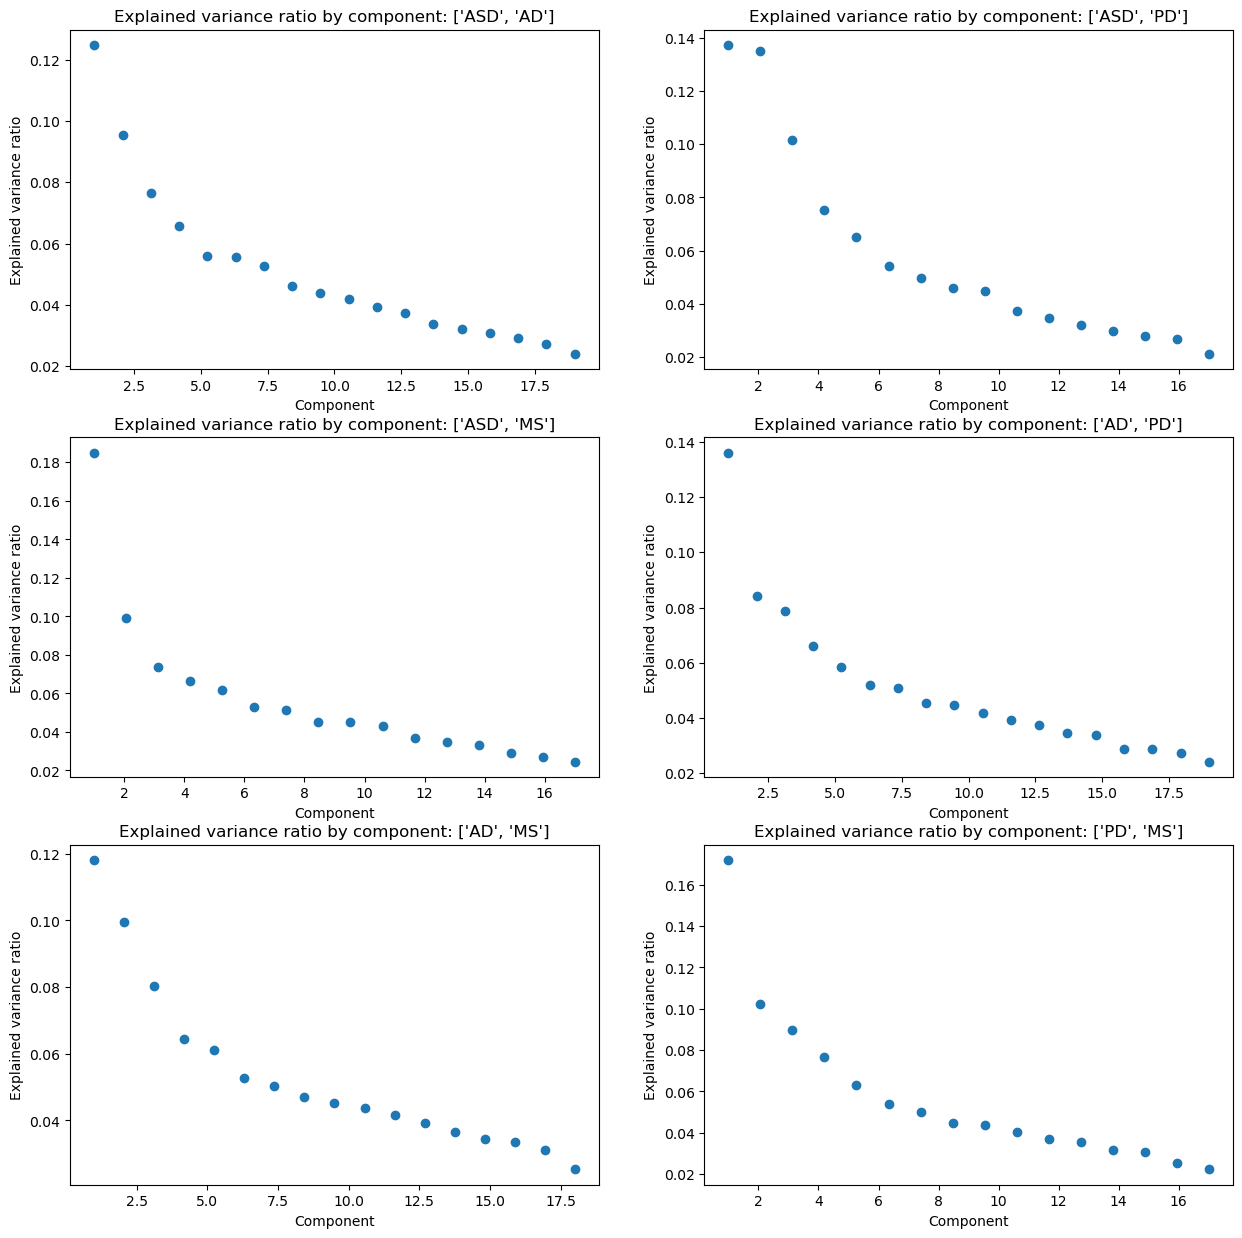

In [5]:
plt.figure(dpi = 200)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 15))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in range(len(out_df_pair)):
    pc = np.linspace(1, len(out_df_pair[i].columns)+1, len(out_df_pair[i].columns))
    axes[i].scatter(pc, var_ratio_pair[i])
    axes[i].set_title('Explained variance ratio by component: ' +  str(pairwise[i]))
    axes[i].set(xlabel='Component')
    axes[i].set(ylabel='Explained variance ratio');

**Visualize clustering by diagnosis with first two PCs:**

<Figure size 1280x960 with 0 Axes>

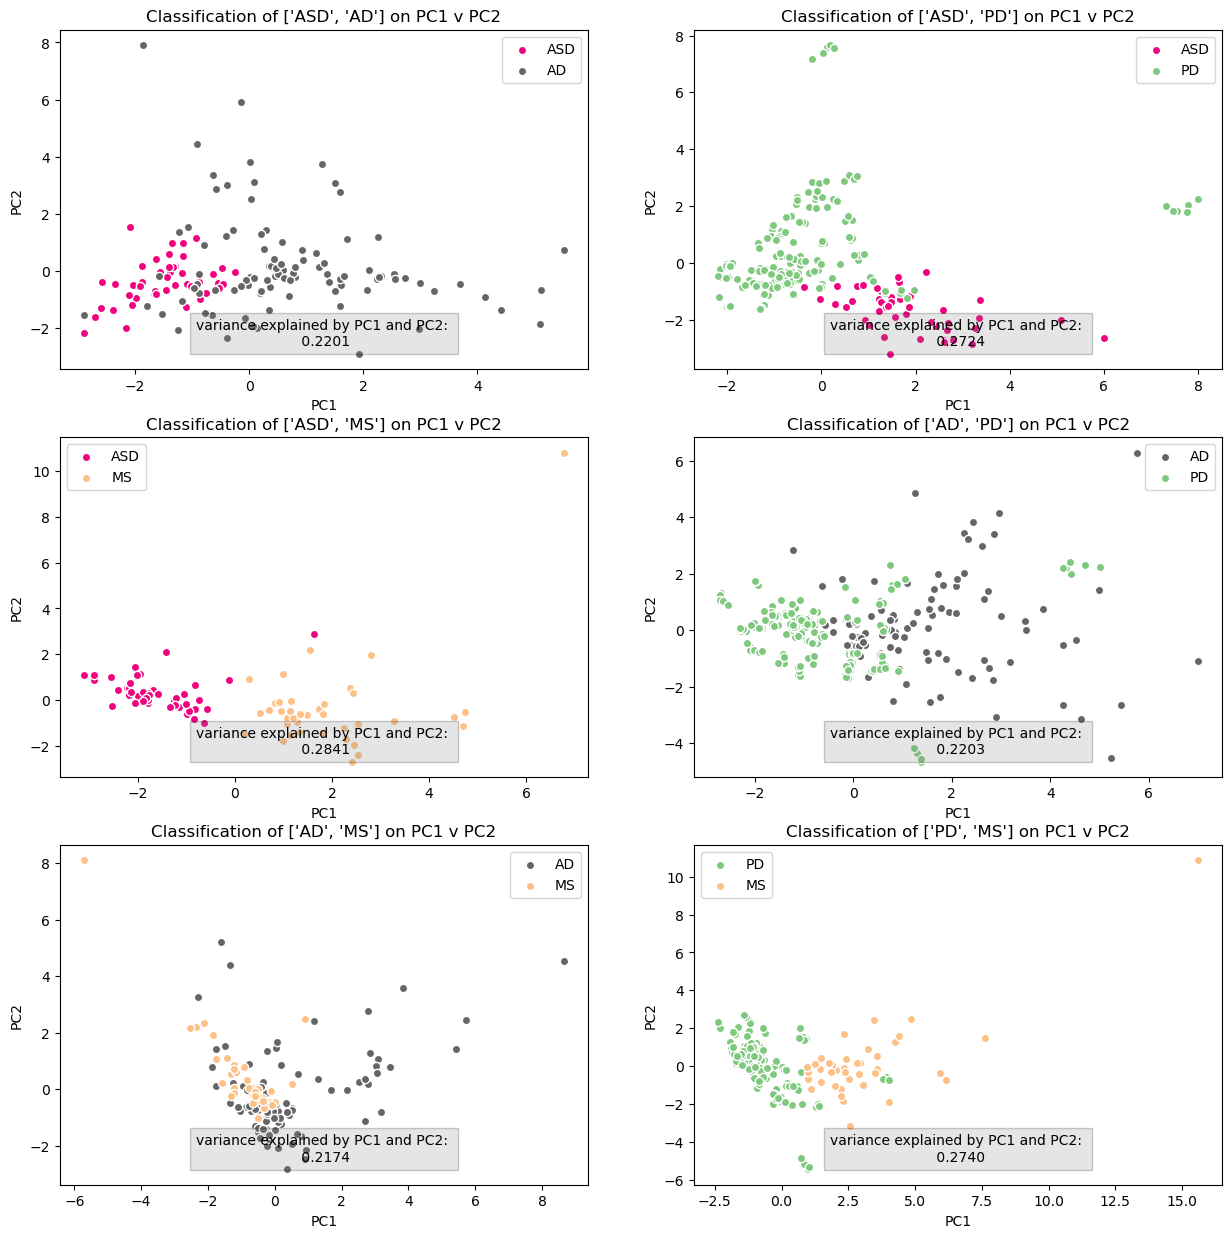

In [6]:
plt.figure(dpi = 200)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 15))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in range(len(out_df_pair)):
    
    diag_1 = []
    diag_2 = []
    
    for j in range(len(diagnosis_pair[i])):
        if diagnosis_pair[i][j]==pairwise[i][0]:
            diag_1.append(j)
        if diagnosis_pair[i][j]==pairwise[i][1]:
            diag_2.append(j)
    
    # plot PC1 v PC2, indicating which indices of these are which disease:
    axes[i].scatter(out_df_pair[i]['PC1'][diag_1], out_df_pair[i]['PC2'][diag_1], label=pairwise[i][0], color = color_map[pairwise[i][0]], edgecolor='white')
    axes[i].scatter(out_df_pair[i]['PC1'][diag_2], out_df_pair[i]['PC2'][diag_2], label=pairwise[i][1], color = color_map[pairwise[i][1]], edgecolor='white')
    
    
    axes[i].legend();
    axes[i].set(xlabel="PC1")
    axes[i].set(ylabel="PC2")
    axes[i].text(0.5, .15, "variance explained by PC1 and PC2: \n {:.4f}".format(var_ratio_pair[i][0] + var_ratio_pair[i][1]), transform=axes[i].transAxes, horizontalalignment='center',
    verticalalignment='top', bbox=dict(facecolor='gray', alpha=0.2))
    axes[i].set_title("Classification of " + str(pairwise[i]) + " on PC1 v PC2");
    
plt.savefig('../Figures/PCA_plots_paired.svg')

**Plot the loadings for the first principal component**

<Figure size 1920x1440 with 0 Axes>

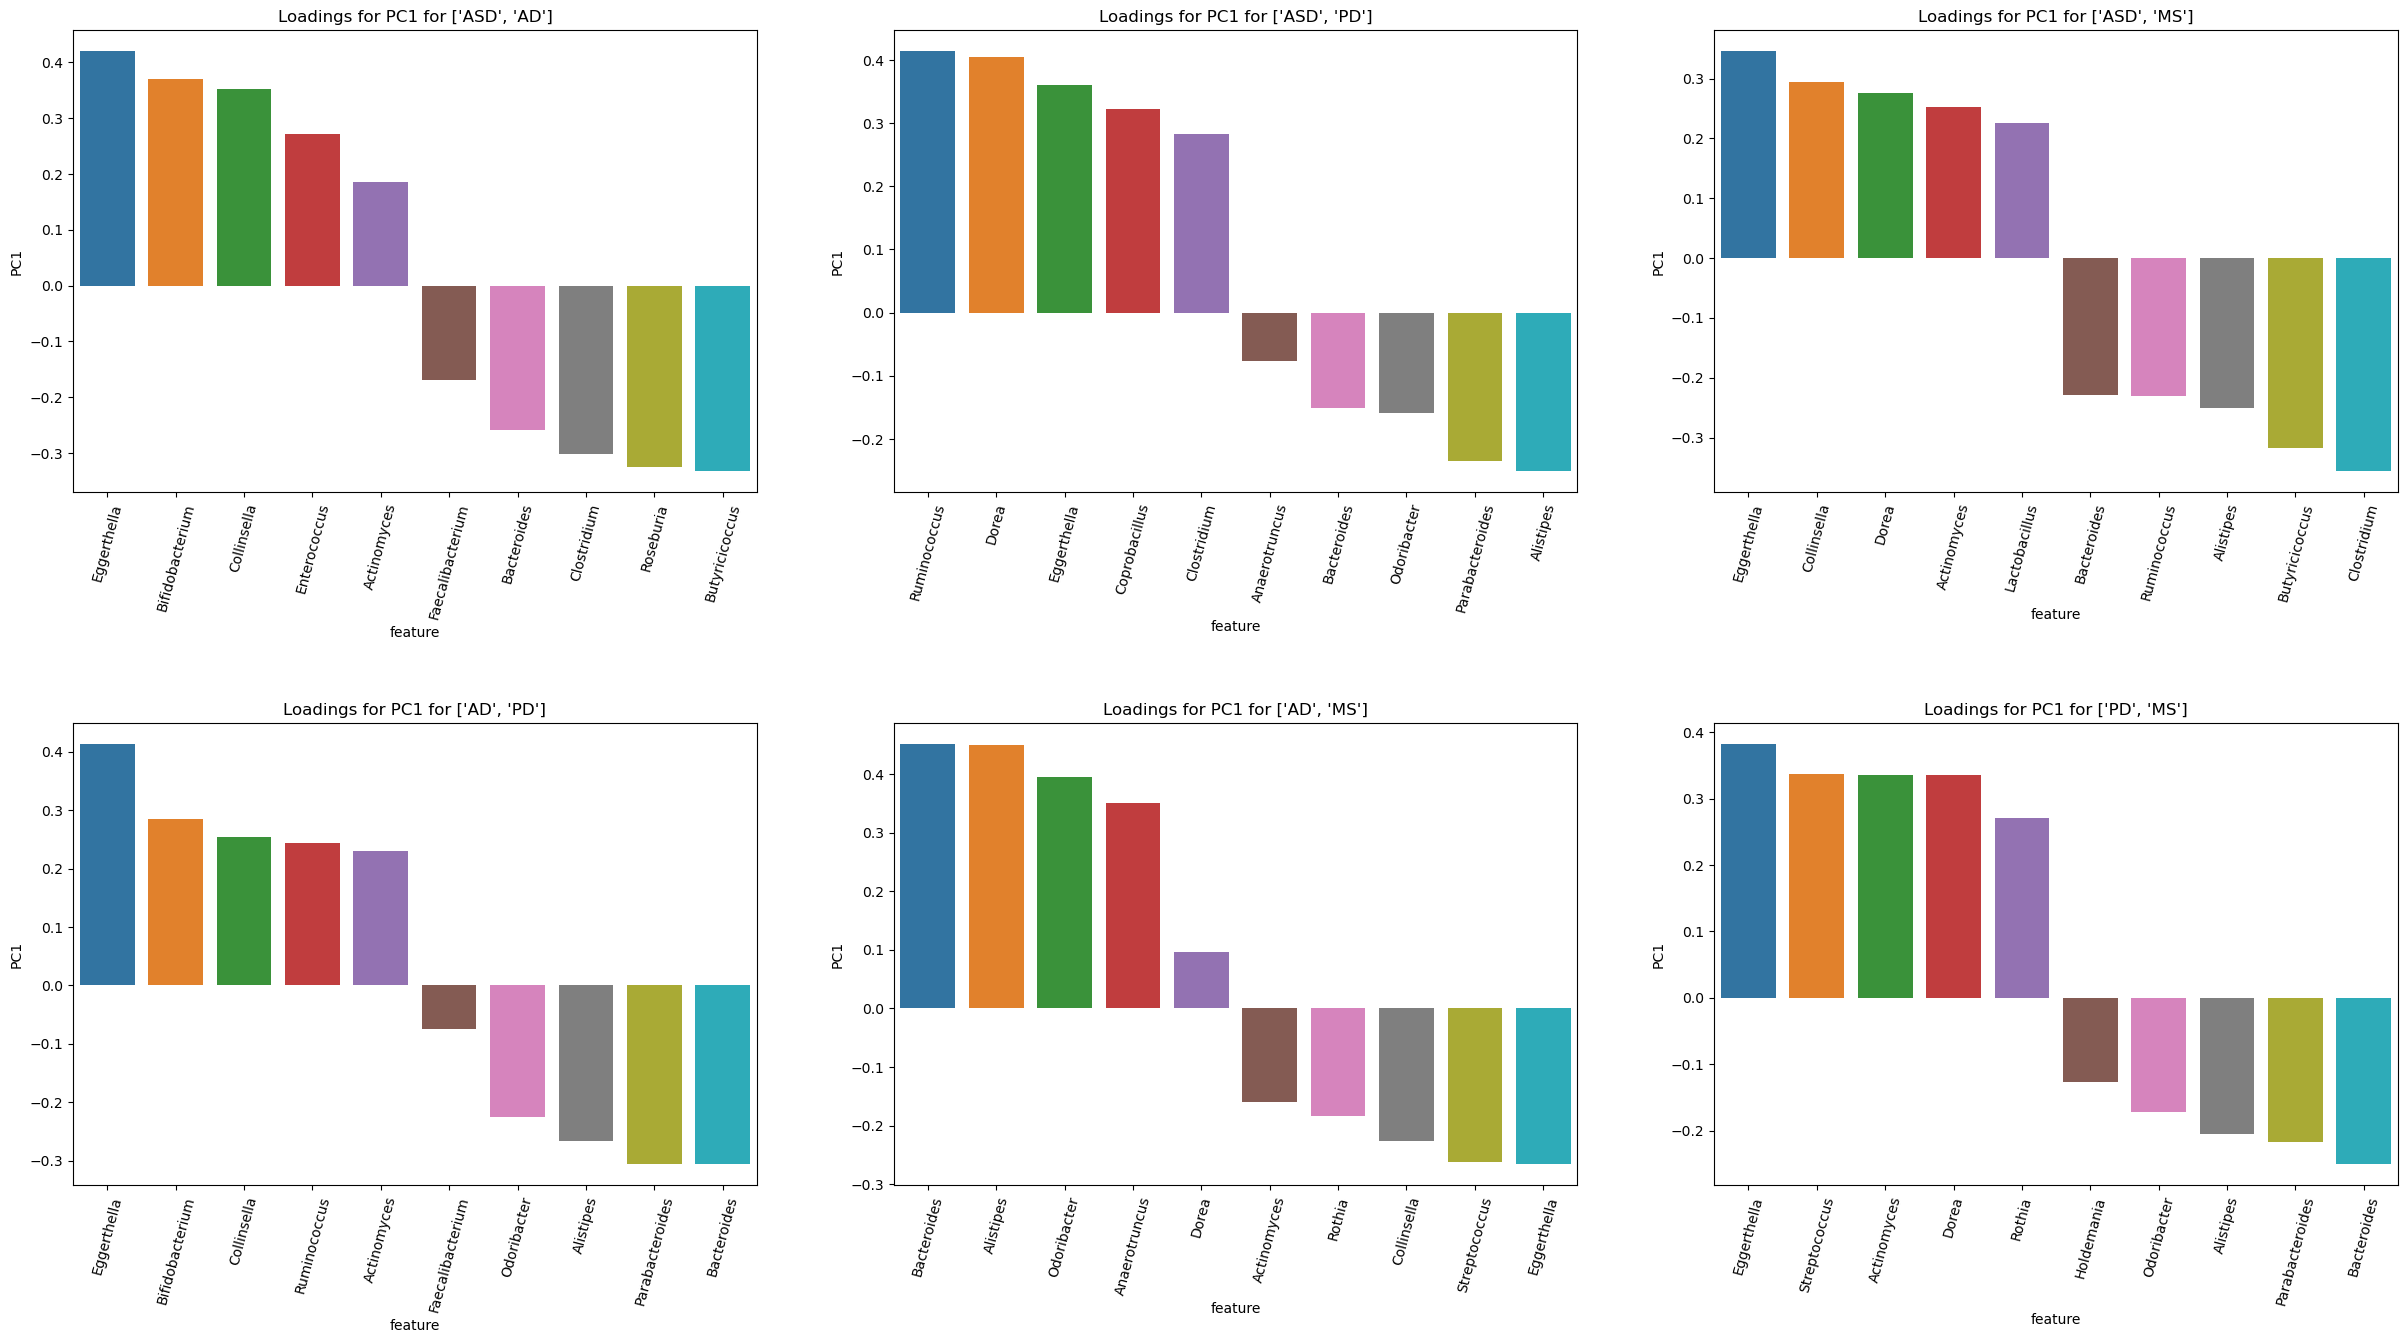

In [7]:
plt.figure(dpi = 300)
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(30, 15))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
plt.subplots_adjust(hspace=.5)
load_list = []

for i in range(len(pcs_pair)):
    pcs = pcs_pair[i]
    # create a dataframe with the load of the features in PC1:
    load = pd.DataFrame(np.transpose(pcs), columns=['PC'+str(i+1) for i in range(len(out_df_pair[i].columns))])
    load["feature"] = list(data_pair_1[i].columns)
    
    # descending values
    load1 = load.sort_values('PC1', ascending=False)
    load1_feat = pd.DataFrame(load1[["feature", 'PC1']], columns=['feature', 'PC1']) # for reference
    load_list.append(list(load1_feat["feature"]))
    

    load_out = pd.concat([load1_feat[:5], load1_feat[-5:]], ignore_index=True)
    
    # plot
    sns.barplot(load_out, x='feature', y='PC1', ax=axes[i]);
    axes[i].set_xticklabels(load_out['feature'], rotation=75);
    axes[i].set_title("Loadings for PC1 for " + str(pairwise[i]));

plt.savefig('../Figures/PCA_load_plots_paired.svg')

## Biplot creation

**Define the function for biplot creation first:**

In [8]:
def biplot(dfScores, dfLoadings, ax):
    ''' directly sourced from https://insidelearningmachines.com/biplot/ . 
    Altered to only show first four loadings (that contribute most to variance), 
    most negative and most positive from PC1 and PC2'''
    
    #make a scores plot

    #set x-axis label
    ax.set_xlabel("PC1",fontsize=10)
    #set y-axis label
    ax.set_ylabel("PC2",fontsize=10)
    
    #create a second set of axes
    ax2 = ax.twinx().twiny()
    
    #setup font dictionary
    font = {'color':  'black',
            'weight': 'bold',
            'size': 12,
            }
    
    # sort the loadings plot:
    dfLoadings = dfLoadings.sort_values('PC1', axis=1, ascending=False)
    dfLoadings1 = dfLoadings.sort_values('PC2', axis=1, ascending=False)

    # color in lines by PC and orient the labels
    b = 0
    v_orient = ["top", "top", "top", "bottom"]
    h_orient = ["left", "right", "right", "right"]
    col_pc = ["red", "red", "blue", "blue"]

    list_show = [dfLoadings.columns.values[0], dfLoadings.columns.values[-1], dfLoadings1.columns.values[0], dfLoadings1.columns.values[-1]]
    
    #make a loadings plot
    
    for col in list_show:    
        #where do our loading vectors end?
        tipx = dfLoadings.loc['PC1',col]
        tipy = dfLoadings.loc['PC2',col]
        #draw the vector, and write label text for col
        ax2.arrow(0, 0, tipx, tipy, color = col_pc[b], alpha = 0.5)
        ax2.text(tipx*1.05, tipy*1.05, col, fontdict = font, ha = h_orient[b], va = v_orient[b])
        b +=1

    ax2.set_xlim(-.75, .75)
    ax2.set_ylim(-.75, .75)
    #align x = 0 of ax and ax2 with the center of figure
    mpl_axes_aligner.align.xaxes(ax, 0, ax2, 0, 0.5)
    #align y = 0 of ax and ax2 with the center of figure
    mpl_axes_aligner.align.yaxes(ax, 0, ax2, 0, 0.5)

**Show the biplots:**

<Figure size 1920x1440 with 0 Axes>

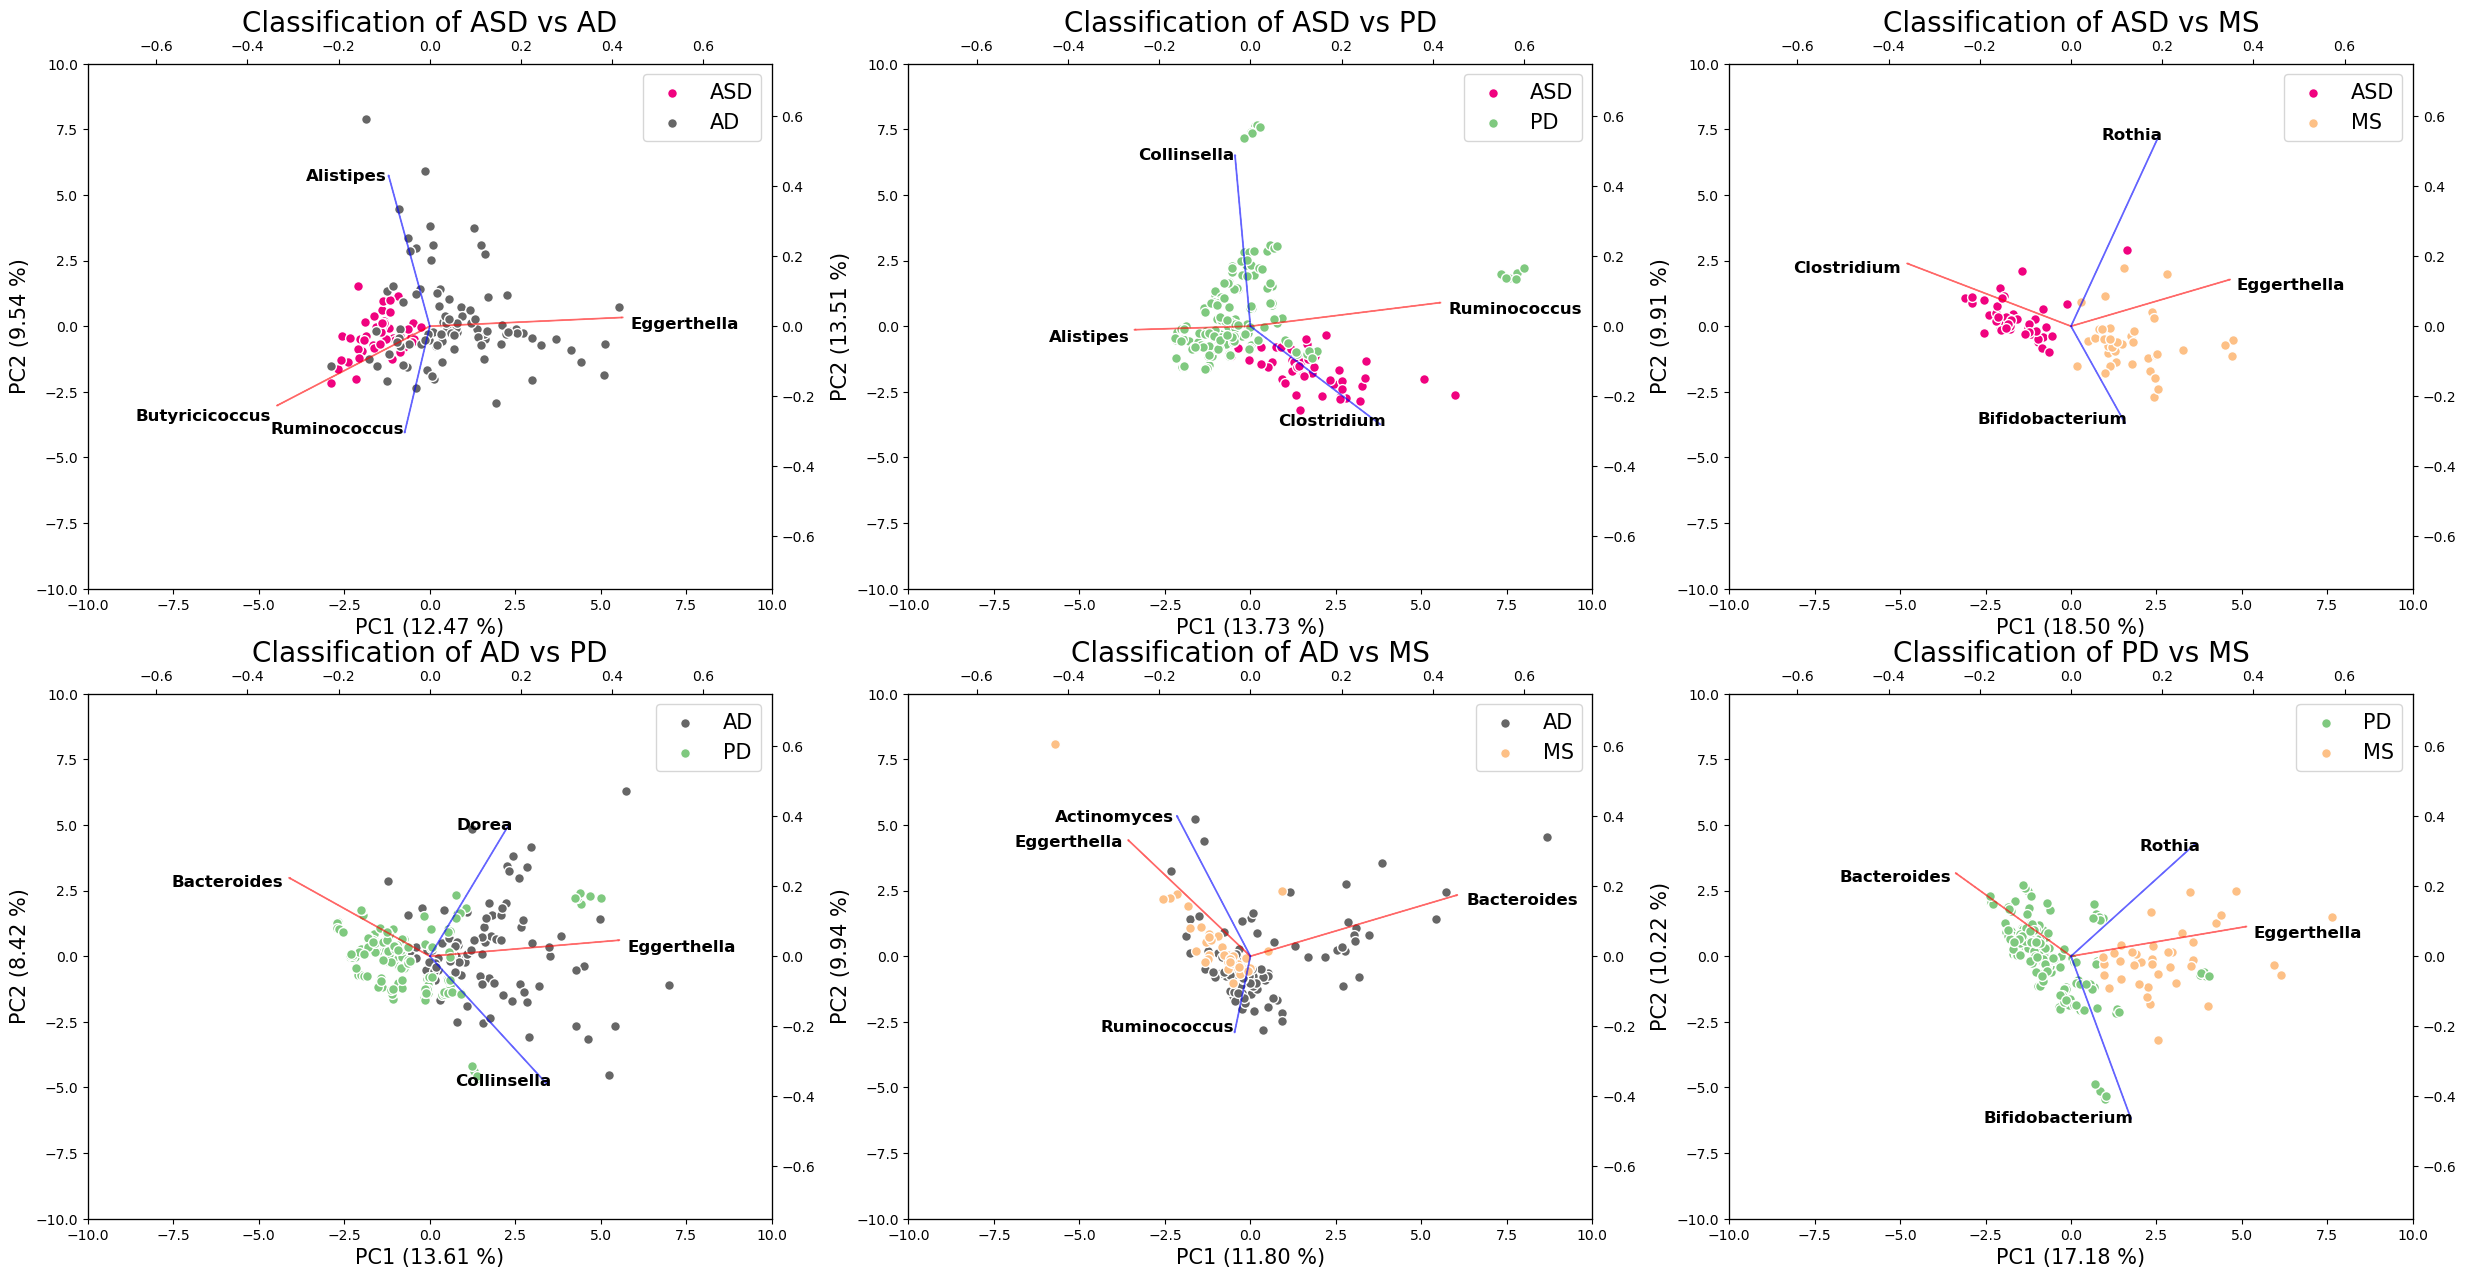

In [9]:
plt.figure(dpi = 300)
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(30, 15))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
plt.subplots_adjust(hspace=.2)

for i in range(len(out_df_pair)):
    
    diag_1 = []
    diag_2 = []
    
    for j in range(len(diagnosis_pair[i])):
        if diagnosis_pair[i][j]==pairwise[i][0]:
            diag_1.append(j)
        if diagnosis_pair[i][j]==pairwise[i][1]:
            diag_2.append(j)
    
    # plot PC1 v PC2, indicating which indices of these are which disease:
    axes[i].scatter(out_df_pair[i]['PC1'][diag_1], out_df_pair[i]['PC2'][diag_1], label=pairwise[i][0], color = color_map[pairwise[i][0]], edgecolor='white', s=50)
    axes[i].scatter(out_df_pair[i]['PC1'][diag_2], out_df_pair[i]['PC2'][diag_2], label=pairwise[i][1], color = color_map[pairwise[i][1]], edgecolor='white', s=50)

    # add in the biplot
    biplot(out_df_pair[i], loadings_pair[i], axes[i])
    axes[i].legend(fontsize=15);

    # also display variance captured by first two PCs
    axes[i].set_xlabel(xlabel="PC1 ({:.2f} %)".format(var_ratio_pair[i][0] * 100), fontsize=15)
    axes[i].set_ylabel(ylabel="PC2 ({:.2f} %)".format(var_ratio_pair[i][1] * 100), fontsize=15)

    axes[i].set_xlim(-10, 10)
    axes[i].set_ylim(-10, 10)
    axes[i].set_title("Classification of " + pairwise[i][0] + ' vs ' + pairwise[i][1], fontsize=20);

plt.savefig('../Figures/PCA_biplots_paired.svg')

**Plot the diseases against the first to loadings from the first PC to visualize any separation**

<Figure size 1920x1440 with 0 Axes>

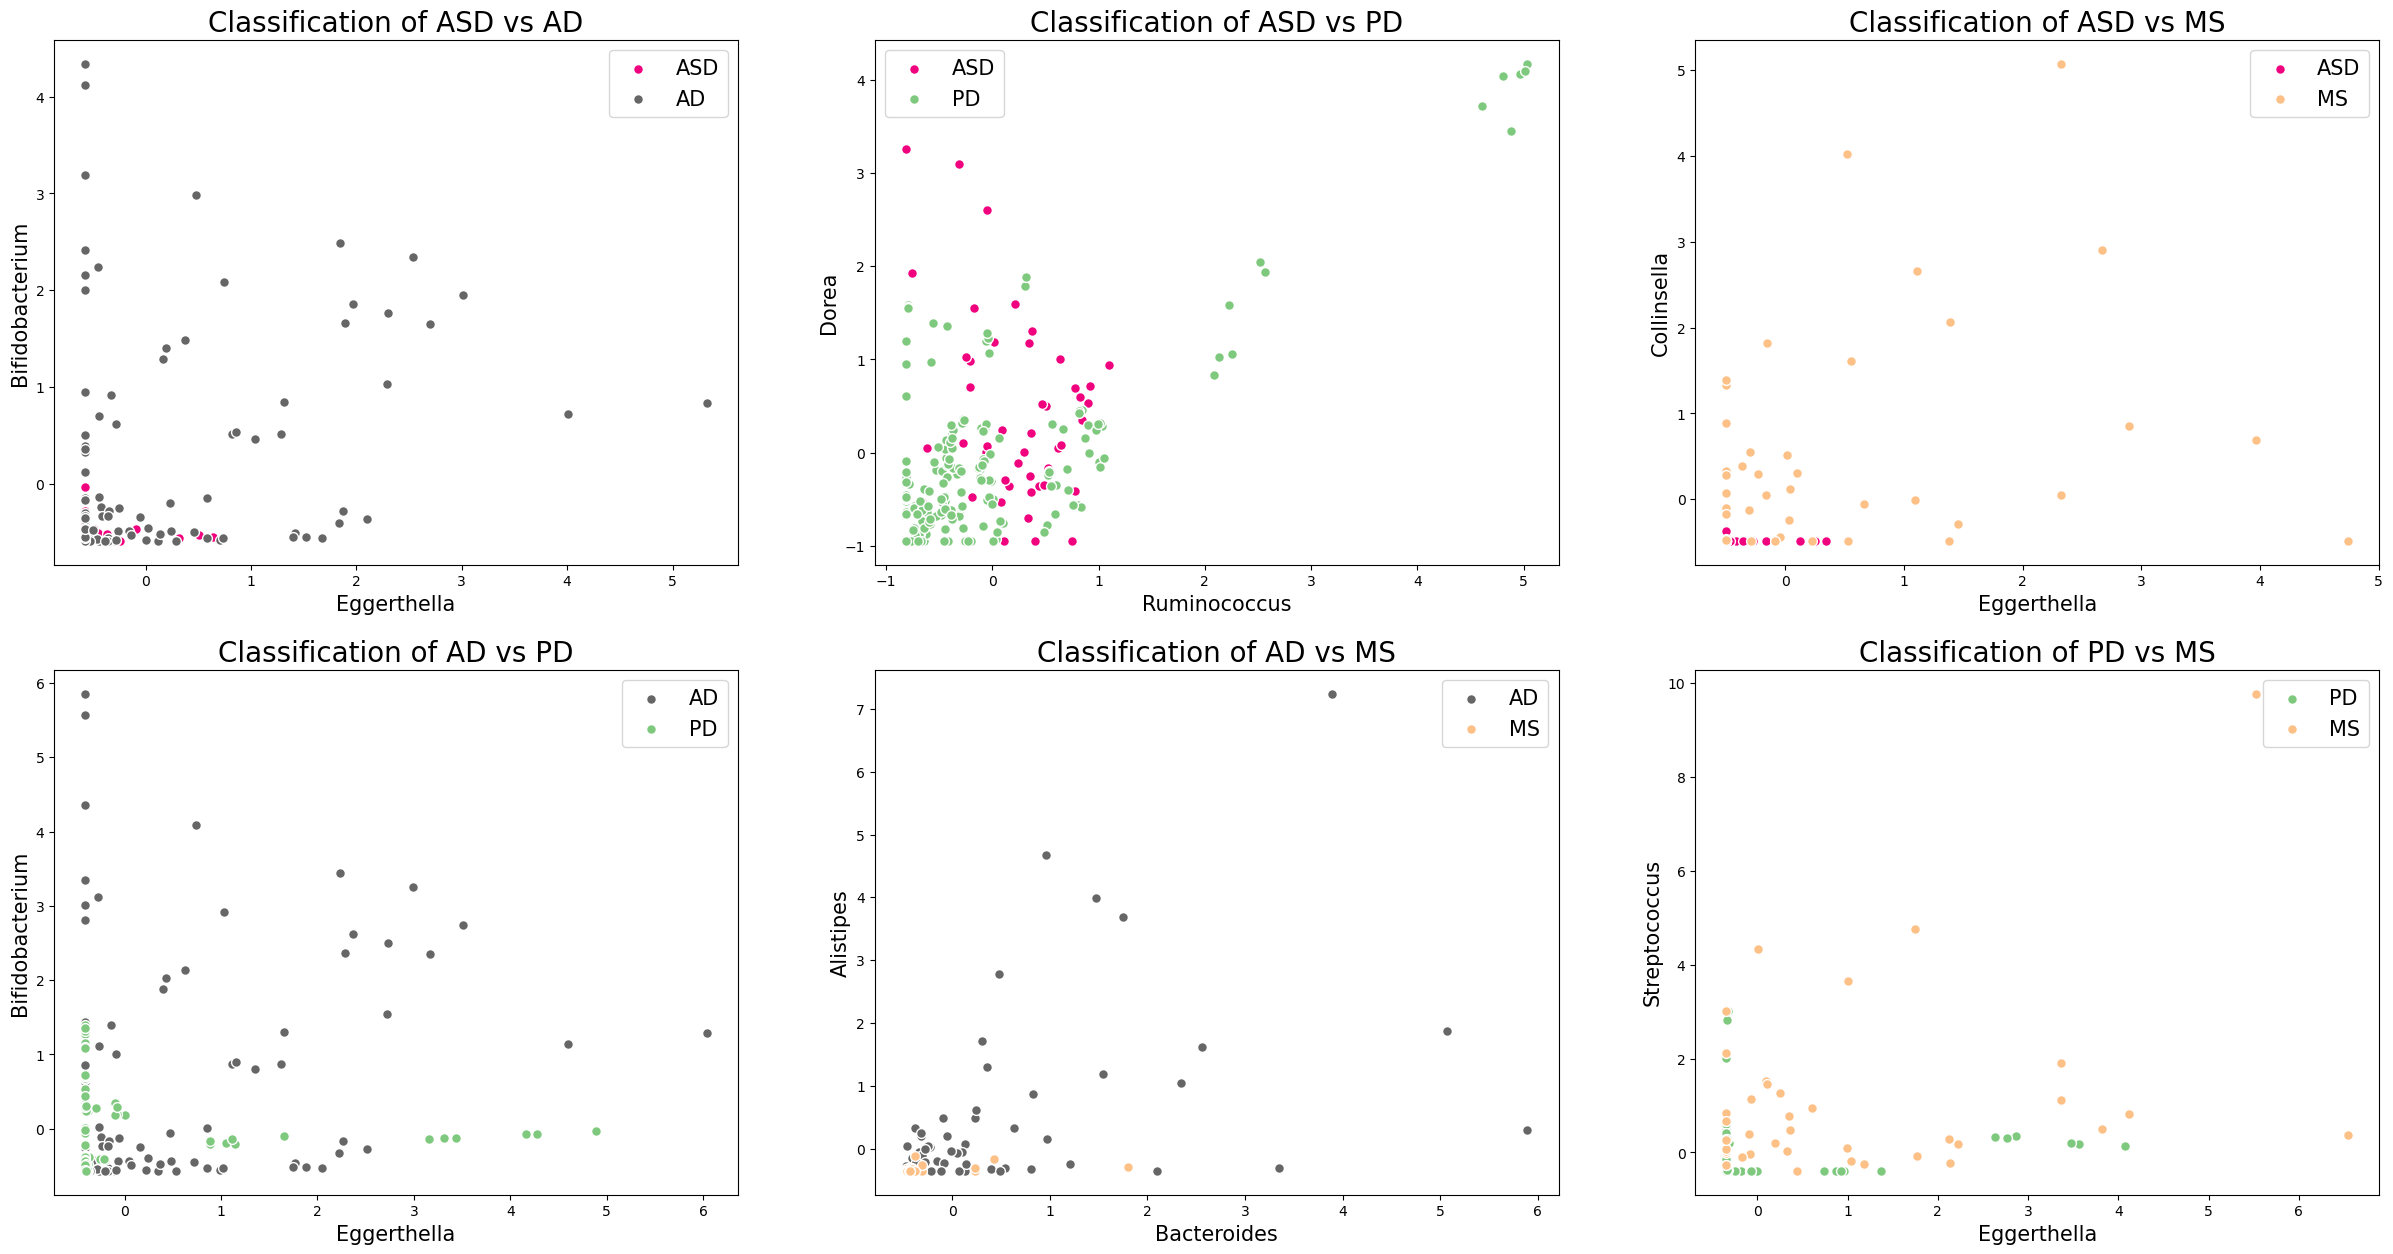

In [10]:
 plt.figure(dpi = 300)
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(30, 15))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
plt.subplots_adjust(hspace=.2)

for i in range(len(out_df_pair)):
    
    diag_1 = []
    diag_2 = []

    feat_1 = load_list[i][0]
    feat_2 = load_list[i][1]
    
    for j in range(len(diagnosis_pair[i])):
        if diagnosis_pair[i][j]==pairwise[i][0]:
            diag_1.append(j)
        if diagnosis_pair[i][j]==pairwise[i][1]:
            diag_2.append(j)
    
    # plot loading 1 and 2 from PC1, indicating which indices of these are which disease:
    axes[i].scatter(data_pair_1[i][feat_1][diag_1], data_pair_1[i][feat_2][diag_1], label=pairwise[i][0], color = color_map[pairwise[i][0]], edgecolor='white', s=50)
    axes[i].scatter(data_pair_1[i][feat_1][diag_2], data_pair_1[i][feat_2][diag_2], label=pairwise[i][1], color = color_map[pairwise[i][1]], edgecolor='white', s=50)
    
    axes[i].legend(fontsize=15);
    
    axes[i].set_xlabel(feat_1, fontsize=15)
    axes[i].set_ylabel(feat_2, fontsize=15)

    axes[i].set_title("Classification of " + pairwise[i][0] + ' vs ' + pairwise[i][1], fontsize=20);

plt.savefig('../Figures/PCA_feat_plots_paired.svg')

## RF Classifier

In [24]:
# these will hold all important information in an easy-to-use format:
diag_test_pair = [] #testing data
diag_train_pair = [] #training data
out_pair = [] # output of RF classification
diag_predict_pair = [] #prediction output on test set
rf_pair = [] # the actual classifier
importance_feat = [] # the importances based on permuation testing

from sklearn.inspection import permutation_importance

for i in range(len(data_pair_1)):
    # set up classifier
    rf = RandomForestClassifier(n_estimators=100) # 100 trees in the forest.
    # 100 trees means 100 sub-samples of data
    
    # make training and testing sets:
    feat_train, feat_test, diag_train, diag_test = sk.model_selection.train_test_split(data_pair_1[i], diagnosis_pair[i], test_size=0.30)
    # chose a test size of 30%
    
    # train:
    out = rf.fit(feat_train, diag_train)
    
    # test:
    diag_predict = rf.predict(feat_test)

    # store info:
    diag_test_pair.append(diag_test)
    diag_train_pair.append(diag_train)
    out_pair.append(out)
    diag_predict_pair.append(diag_predict)
    # permutation testing with 100 repeats:
    perm_importance = permutation_importance(rf, feat_test, diag_test, n_repeats=100)
    importance_feat.append(perm_importance)
    rf_pair.append(rf)

**Accuracy of classifier**

In [25]:
for i in range(len(diag_test_pair)):
    acc = sk.metrics.accuracy_score(diag_test_pair[i], diag_predict_pair[i])
    print("accuracy for " + str(pairwise[i]) + " {:.3f}".format(acc))

accuracy for ['ASD', 'AD'] 0.933
accuracy for ['ASD', 'PD'] 1.000
accuracy for ['ASD', 'MS'] 1.000
accuracy for ['AD', 'PD'] 1.000
accuracy for ['AD', 'MS'] 0.976
accuracy for ['PD', 'MS'] 0.986


**Plot of most important features for classification**

In [26]:
imp_table_pair = []
df_imp = []

# store info in tables
for i in range(len(data_pair_1)):
    # find importance of each feature:
    feat = data_pair_1[i].columns
    feat_importance = rf_pair[i].feature_importances_
    
    # make and print table of ranked features by importance:
    imp_table = pd.DataFrame(feat, columns=['features'])
    imp_table['importance'] = feat_importance
    imp_table_sort = imp_table.sort_values('importance', ascending=False)
    imp_table_sort = imp_table_sort.round(3)
    feat_sort = list(imp_table_sort['features']) # use this for plotting and storing the features
    imp_table_pair.append(feat_sort)
    df_imp.append(imp_table_sort)
    # save them for later use:
    imp_table_sort.to_csv('../Data/feature_importance/' + "feature_importance_" + pairwise[i][0] + '_' + pairwise[i][1] + '.csv')  

<Figure size 1920x1440 with 0 Axes>

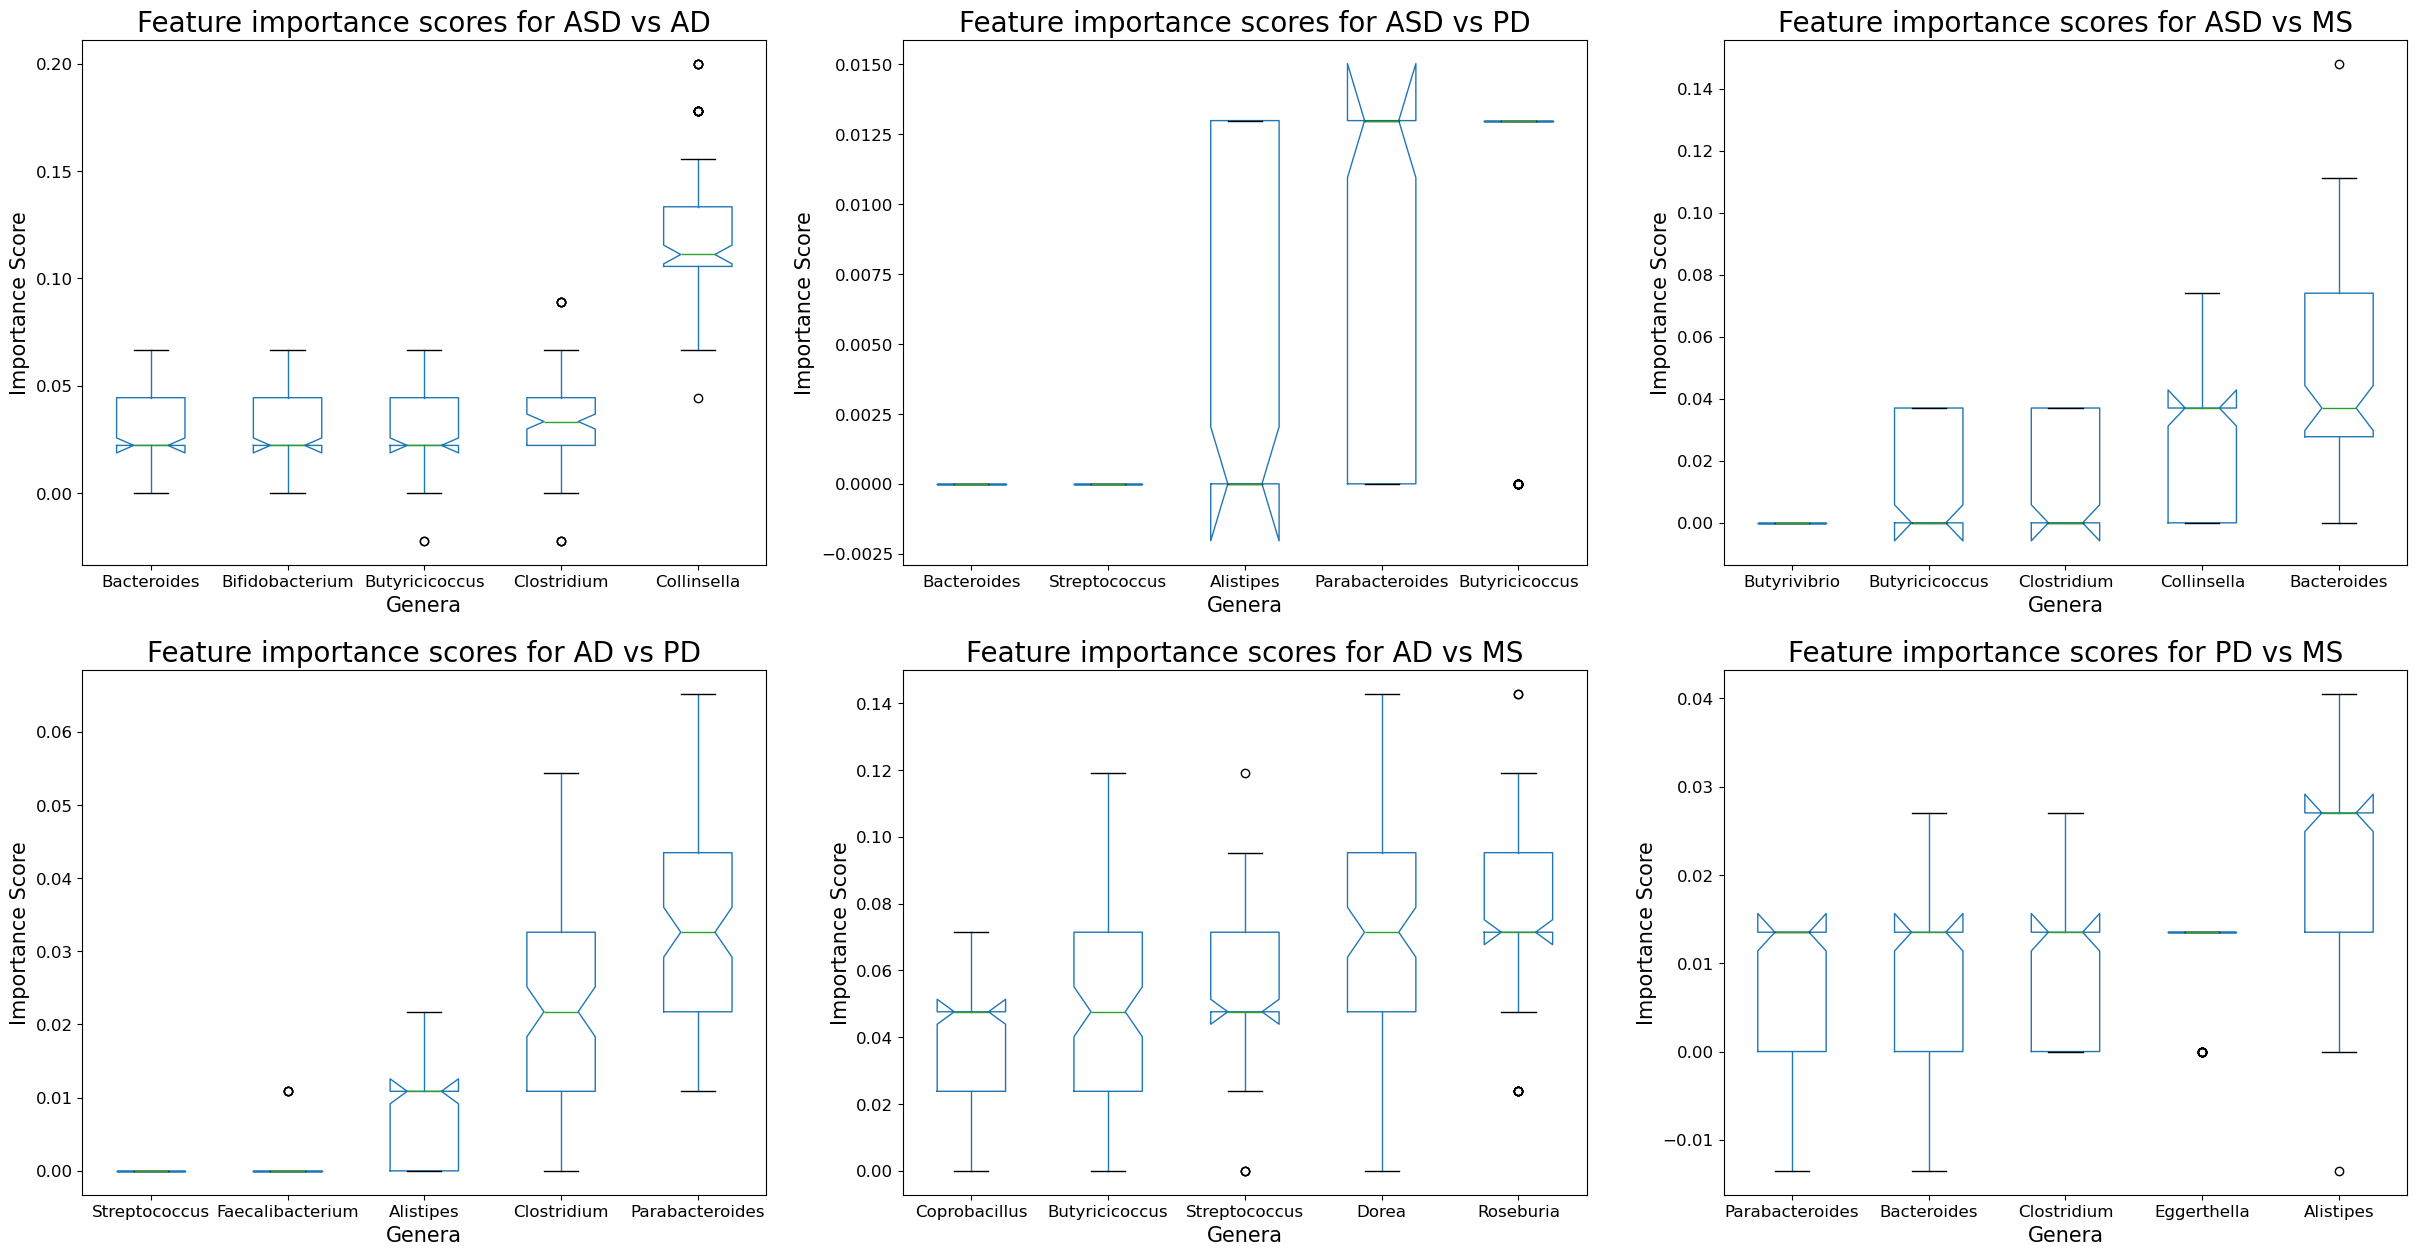

In [27]:
imp_data = []

# get the data from the permutation testing:
for i in range(len(pairwise)):
    sorted_id = importance_feat[i].importances_mean.argsort()
    imp_data.append(pd.DataFrame(importance_feat[i].importances[sorted_id].transpose(), columns=data_pair_1[i].columns[sorted_id]))

# plot using a box and whisker plot:
plt.figure(dpi = 300)
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(30, 15))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]


for i in range(len(pairwise)):
    imp_data[i].boxplot(list(imp_data[i].columns[-5:]), grid=False, ax=axes[i], meanline=True, fontsize=12, notch=True)
    axes[i].set_xlabel(xlabel="Genera", fontsize=15)
    axes[i].set_ylabel(ylabel="Importance Score", fontsize=15)
    axes[i].set_title("Feature importance scores for " + str(pairwise[i][0]) + ' vs ' + str(pairwise[i][1]), fontsize=20);

plt.savefig('../Figures/RF_importance_plots_paired.svg')

**XY scatter of important features**

<Figure size 1920x1440 with 0 Axes>

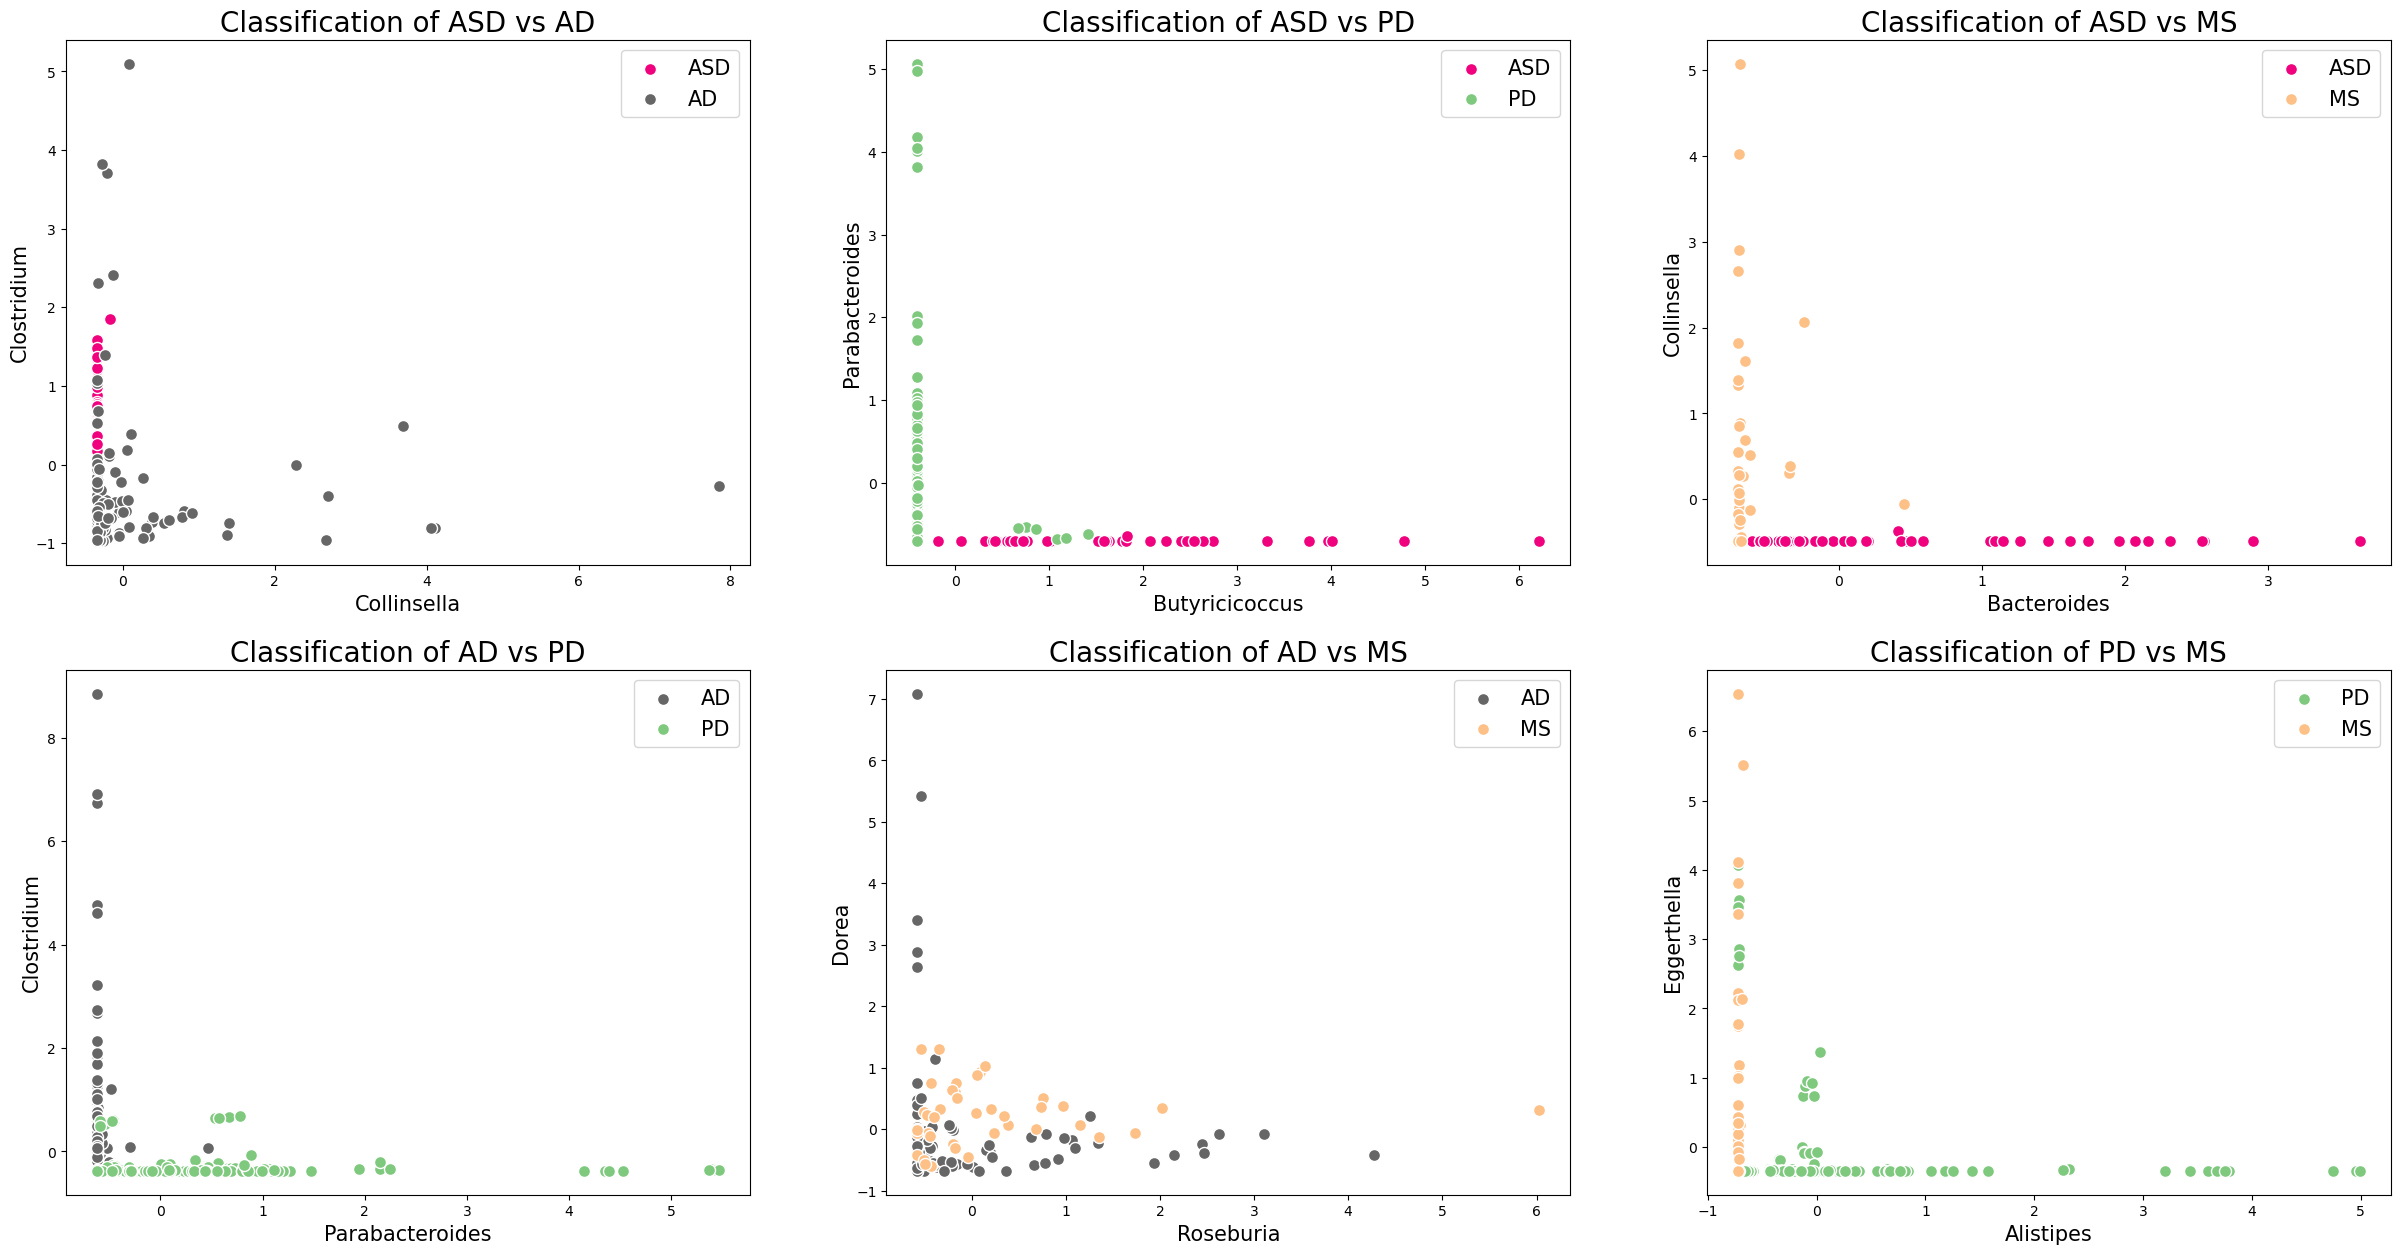

In [28]:
plt.figure(dpi = 300)
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(30, 15))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in range(len(data_pair_1)):

    diag_1 = []
    diag_2 = []

    feat1 = imp_data[i].columns[-1]
    feat2 = imp_data[i].columns[-2]
    
    for j in range(len(data_pair_1[i])):
        if diagnosis_pair[i][j]==pairwise[i][0]:
            diag_1.append(j)
        if diagnosis_pair[i][j]==pairwise[i][1]:
            diag_2.append(j)
    
    # use the top two most important features from the table of ranked importances

    axes[i].scatter(data_pair_1[i].reset_index()[feat1][diag_1], data_pair_1[i].reset_index()[feat2][diag_1], label=pairwise[i][0], color = color_map[pairwise[i][0]], edgecolor='white', s=75)
    axes[i].scatter(data_pair_1[i].reset_index()[feat1][diag_2], data_pair_1[i].reset_index()[feat2][diag_2], label=pairwise[i][1], color = color_map[pairwise[i][1]], edgecolor='white', s=75)
    
    axes[i].legend(fontsize=15);
    
    axes[i].set_xlabel(feat1, fontsize=15);
    axes[i].set_ylabel(feat2, fontsize=15);
    
    axes[i].set_title("Classification of " + str(pairwise[i][0]) + ' vs ' + str(pairwise[i][1]), fontsize=20);
plt.savefig('../Figures/RF_feature_plots_paired.svg')

**Look at Gini importance and get decision tree**

In [29]:
# followed this tutorial for getting image: https://naysan.ca/2019/11/26/visualize-a-decision-tree-with-sklearn/
# i just plotted one of the trees:
graphs = []
Images = []
for i in range(len(out_pair)):
    out_file = sk.tree.export_graphviz(out_pair[i][1], label='all', feature_names=imp_table_pair[i], class_names= pairwise[i])
    
    graphs.append(pydotplus.graph_from_dot_data(out_file))
    Images.append(Image(graphs[i].create_png()))

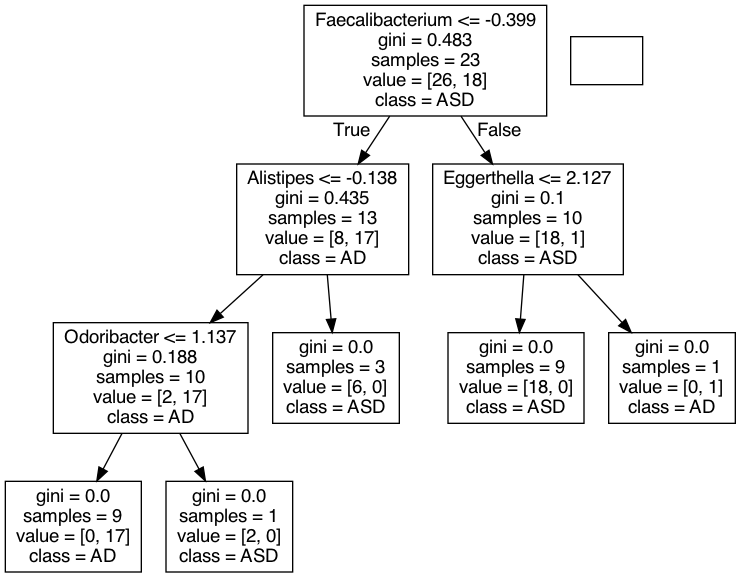

In [17]:
Images[0]